# A basic Demonstration of MetaCast

MetaCast has been developed from the codebase used in [Grunnill et al. (2024)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011018). MetaCast's main feature is broad**CAST**ing epidemiological and ecological subpopulation models over multiple dimensions (axis) to form a **META**population model.

This notebook uses a disease X $S E I H R$ (Susceptible - Exposed - Infected - Hospitalised - Recovered) subpopulation model as a motivating example. In possible scenarios in outbreak of disease X that epidemiological modellers my wish to simulate:
1. Risk-Structured: Single Dimension/Axis disease X model.
2. Seeding at X% prevalence: MultinomialSeeder
3. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.
4. New Vaccine: Multi Dimension/Axis disease X model with flows between some subpopulations.
5. New Vaccine's Efficacy is Uncertain: Latin Hypercube Sampling in simulation of a 2 dimensional/axis disease X model.


#### Suggested Reading: Metapopulation and Structured Population Models.

**Note** MetaCast has tried to keep to the mathematical notation seen in the first of the following:

Keeling, M. J., & Rohani, P. (2008). Metapopulations. In Modeling Infectious Diseases in Humans and Animals (pp. 237–240). Princeton University Press.

Keeling, M. J., & Rohani, P. (2008). Age-Structure: Childhood Infections. In Modeling Infectious Diseases in Humans and Animals (pp. 77–92). Pinston University Press.

#### Suggested Reading: Performing Sensitivity Analyses.

Marino, S., Hogue, I. B., Ray, C. J., & Kirschner, D. E. (2008). A methodology for performing global uncertainty and sensitivity analysis in systems biology. In Journal of Theoretical Biology (Vol. 254, Issue 1, pp. 178–196). [https://doi.org/10.1016/j.jtbi.2008.04.011](https://doi.org/10.1016/j.jtbi.2008.04.011)

#### Suggested Reading: Demonstrating a Scenario Analyses that can be Performed using this Package

Grunnill, M., Arino, J., McCarthy, Z., Bragazzi, N. L., Coudeville, L., Thommes, E., Amiche, A., Ghasemi, A., Bourouiba, L., Tofighi, M., Asgary, A., Baky-Haskuee, M., & Wu, J. (2024). Modelling Disease Mitigation at Mass Gatherings: A Case Study of COVID-19 at the 2022 FIFA World Cup. In E. H. Lau (Ed.), PLoS Computational Biology: Vol. January (Issue 1, p. e1011018). Public Library of Science. [https://doi.org/10.1371/JOURNAL.PCBI.1011018](https://doi.org/10.1371/JOURNAL.PCBI.1011018)

# 1. Risk-Structured: Single Dimension/Axis disease X model.

In this section we will be using our model with two groups one at high risk of hospitalisation and another at a low risk, as shown in the equations below. The $r$ subscript denotes risk group, $p_{r}$ denotes the probability of becoming hospitalised for that risk group and $\lambda_{r}$ is the force of infection for that risk group. $\sigma^{-1}$ is the latency period. After $\gamma^{-1}$ days infectious individuals either recover ($1-p_{r}$) or are hospitalised ($p_{r}$). Hospitalised individuals recover after $\eta^{-1}$ days.
$$
    \frac{\delta S_{r}}{\delta t} = -\lambda_{r} S_{r}
$$
$$
    \frac{\delta E_{r}}{\delta t} = \lambda_{r} S_{r} - \sigma E_{r}
$$
$$
    \frac{\delta I_{r}}{\delta t} = \sigma E_{r} - \gamma I_{r}
$$
$$
    \frac{\delta H_{r}}{\delta t} = p_{r} \gamma I_{r} - \eta H_{r}
$$
$$
    \frac{\delta R_{r}}{\delta t} = (1-p_{r}) \gamma I_{r} + \eta H_{r}
$$

The force of infection ($\lambda_{r}$), shown below, for subpopulation $i$ is dependent on the number of infecteds in subpopulation $j$, the strength of interaction between subpopulation those subpopulations ($\rho_{ij}$) and the general transmission term for subpopulation $i$ ($\beta_{i}$).
$$
    \lambda_{i} = \beta_{i} \sum_{j} \rho_{ij} I_j
$$

## 1.1 MetaCaster setup

MetaCast's main workhorse is the MetaCaster class. This needs to be imported.

In [1]:
from metacast import MetaCaster # Import MetaCast's main class MetaCaster.

### 1.1.1 Define subpopulation model.

The subpop_model function is your subpopulation model (see 1.) that MetaCaster will broadcast across the metapopulation generated by your dimensions (see 1.2).
The docstring below explains how the required arguments are used by MetaCaster.

In [2]:
def subpop_model(y, y_deltas, parameters, states_index, subpop_suffix, foi):
    """
    Calculate derivatives of variables in disease X's subpopulation model

    Parameters
    ----------
    y : numpy.Array
        An array of the state variables at this time point.
    y_deltas : numpy.Array
        The derivatives of y at this time. MetaCaster gives y_delta as a numpy array of zeros to which this function adds the derivatives to.
    parameters : dict {str: Number or callable}
        A dictionary of parameter values or callables used to calculate parameter values at this time point.
    subpop_suffix : string
        This string is of the form '_['coodinate_1,coordinate_2,....']' and is appended to a string denoting parameter specifcally applied to this subpopulation. Alternatively a coordinates argument can be given.
    states_index : dict {str:int}
        This dictionary is used to look up the indexes on y and y_delta for states is this subpopulation.
    foi : float
        Force of infection (lambda) experienced be susceptible hosts in this subpopulation. Note the term lambda could not be used as it is used for lambda functions within python. Therefore, the term foi (Force Of Infection) is used.

    Returns
    -------
    y_deltas : numpy.Array
        Derivatives of variables in disease X's subpopulation model.

    """
    infections = foi * y[states_index['S']]
    progression_from_exposed = parameters['sigma'] * y[states_index['E']]
    probability_of_hospitalisation = parameters['p' + subpop_suffix] # this is our subpopulation specific parameter
    progression_from_infectious = y[states_index['I']]*parameters['gamma']
    recovery = progression_from_infectious*(1-probability_of_hospitalisation)
    hospitalisation = progression_from_infectious*probability_of_hospitalisation
    hospital_recovery = y[states_index['H']]*parameters['eta']


    # Updating y_deltas with derivative calculations from this subpopulation.
    y_deltas[states_index['S']] += - infections
    y_deltas[states_index['E']] += infections - progression_from_exposed
    y_deltas[states_index['I']] += progression_from_exposed - progression_from_infectious
    y_deltas[states_index['H']] += hospitalisation - hospital_recovery
    y_deltas[states_index['R']] += recovery+hospital_recovery
    y_deltas[-2] += hospitalisation - hospital_recovery # The last few elements of y_delta can be used for observed states such Total hospital incidence.
    y_deltas[-1] += hospitalisation #or Total hospitalisations.

    return y_deltas

### 1.1.2 Define metapopulation dimensions.

In this first example we are assuming structure comes from just the risk of hospitalisation (low and high). As we are dealing with a one dimension axis metapopulation we can provide a set of strings as our dimensions (a list/tuple of unique strings is also acceptable). **Note** if dealing with a multidimensional metapopulation the dimensions would have to be a list/tuple of sets of strings.

In [3]:
risk_groups = ['low', 'high']

### 1.1.3 Define other model attributes

In [4]:
other_model_attributes = {
    'states': ['S', 'E', 'I', 'H', 'R'], # States of our model
    'infected_states': ['E', 'I'], # Infected states of our model, this is different from infectious states.
    'infectious_states': ['I'], # Infectious states of our model. These will be involved in force of infection calculations.
    'symptomatic_states': ['I', 'H'], # List symptomatic states
    'observed_states': ['H','H_cumulative'], # observed_states is where we name what is being tracked in the last few elements of y_deltas.
    'universal_params': ['sigma', 'gamma', 'eta'], # These are parameters that are not specific to subpopulations.
    'subpop_params': ['p'] # These are parameter that are specific to subpopulation, but not those included in transmission (i.e. beta and rho).
}

### 1.1.3 Intialise MetaCaster.

In [5]:
metapop_model = MetaCaster(dimensions=risk_groups, subpop_model=subpop_model, **other_model_attributes)

*Note* if you are familiar with python you could alternatively initialise your own subclass of MetaCaster with just the dimensions argument. You would need to replace that subclass's subpop_model method and give it the attributes seen in other_model_attributes.

# 1.2 Running model
## 1.2.1 Setting population

For this we will need numpy.

In [6]:
import numpy as np

We need the state_index dictionary for each subpopulation. This gives us our indexes to use on the numpy array defining our initial population $y$.

In [7]:
state_index_dict_high = metapop_model.state_index['high']
state_index_dict_low = metapop_model.state_index['low']
display(state_index_dict_low, state_index_dict_high)

{'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9}

{'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4}

Now we can define $y$.

In [8]:
N = 1e6
proportion_high_risk = 0.1
low_risk_population = N*(1-proportion_high_risk)
high_risk_population = N*proportion_high_risk
y = np.zeros(metapop_model.total_states) # Use the total number of states in our model to define y.
y[state_index_dict_low['S']] = low_risk_population-1
y[state_index_dict_low['I']] = 1
y[state_index_dict_high['S']] = high_risk_population
y

array([1.00000e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       8.99999e+05, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00])

### 1.2.2 Setting up parameters

For this we will need to know the names of all of our parameters:

In [9]:
metapop_model.parameter_names

['beta_[high]',
 'beta_[low]',
 'eta',
 'gamma',
 'p_[high]',
 'p_[low]',
 'rho_[high]_[high]',
 'rho_[high]_[low]',
 'rho_[low]_[high]',
 'rho_[low]_[low]',
 'sigma']

Now we can define our parameters in a dictionary.

In [10]:
non_subpop_parameters = {'eta': 1/5, 'gamma': 1/7,  'sigma': 1/3}
p_high = 0.3
p_low = 0.01
hospitalisation_probs = {'p_[high]': p_high, 'p_[low]': p_low}
beta = (2/7)/N
beta_parameters = {'beta'+ subpop_suffix: beta for subpop_suffix in metapop_model.subpop_suffixes}
rho = 1
interaction_parameters = {'rho'+ subpop_suffix_i+subpop_suffix_j: rho
                          for subpop_suffix_i in metapop_model.subpop_suffixes
                          for subpop_suffix_j in metapop_model.subpop_suffixes}
parameters = {**non_subpop_parameters,
              **hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
parameters

{'eta': 0.2,
 'gamma': 0.14285714285714285,
 'sigma': 0.3333333333333333,
 'p_[high]': 0.3,
 'p_[low]': 0.01,
 'beta_[high]': 2.857142857142857e-07,
 'beta_[low]': 2.857142857142857e-07,
 'rho_[high]_[high]': 1,
 'rho_[high]_[low]': 1,
 'rho_[low]_[high]': 1,
 'rho_[low]_[low]': 1}

We can now use our parameter dictionary to assign our parameter values.

In [11]:
metapop_model.parameters = parameters

### 1.2.3 Run metapopulation model

Before running our model we need to define our timeframe $t$.

In [12]:
#set time
end_day = 90
time_step = 1
t = np.arange(0, end_day+time_step, time_step)
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

Now we can use $y$ and $t$ with the integrate method to simulate our model.

In [13]:
results_1 = metapop_model.integrate(y,t)
results_1

high                                                \
                S          E           I          H           R   
0   100000.000000   0.000000    0.000000   0.000000    0.000000   
1    99999.972985   0.022911    0.003908   0.000056    0.000140   
2    99999.947570   0.038014    0.013053   0.000369    0.000994   
3    99999.922182   0.048841    0.024924   0.001041    0.003012   
4    99999.895846   0.057424    0.038181   0.002084    0.006465   
..            ...        ...         ...        ...         ...   
86   99679.171312  64.975344   95.280960  14.350610  146.221775   
87   99650.860927  70.688384  103.675520  15.616509  159.158659   
88   99620.066034  76.899683  112.805318  16.993571  173.235394   
89   99586.570815  83.651946  122.733948  18.491464  188.551827   
90   99550.141119  90.991403  133.530356  20.120679  205.216442   

              low                                                  \
                S           E            I         H            R   
0   899999.000000    0.000000     1.000000  0.000000     0.000000   
1   899998.756863    0.206203     0.902053  0.001220     0.133660   
2   899998.528128    0.342128     0.868956  0.002140     0.258649   
3   899998.299639    0.439570     0.875754  0.002878     0.382159   
4   899998.062612    0.516814     0.908351  0.003510     0.508713   
..            ...         ...          ...       ...          ...   
86  897111.545018  584.777444   857.527688  4.305178  1441.844671   
87  896856.751838  636.194751   933.078650  4.684948  1569.289813   
88  896579.598102  692.096376  1015.246741  5.098066  1707.960715   
89  896278.141473  752.866680  1104.604306  5.547433  1858.840108   
90  895950.274569  818.921720  1201.771874  6.036197  2022.995640   

   observed_states               
                 H H_cumulative  
0         0.000000     0.000000  
1         0.001276     0.001407  
2         0.002509     0.003017  
3         0.003919     0.005066  
4         0.005593     0.007687  
..             ...          ...  
86       18.655788    62.633214  
87       20.301457    68.172298  
88       22.091637    74.199277  
89       24.038897    80.756863  
90       26.156877    87.891455  

[91 rows x 12 columns]

### 1.2.4 Plotting hospitalisations

Let's plot some of the results of our simulation. For this we will need seaborn and pandas.

In [14]:
import seaborn as sns
import pandas as pd

The function below unstacks our reslults so they can be used by seaborn and then plots the number or hospitalisation ($H$) in our subpopulations and observed_states.

In [15]:
def unstack_results_and_plot_hospitalised(results):
    results_unstacked = results.unstack()
    results_unstacked = results_unstacked.reset_index()
    results_unstacked.columns = ['Subpopulation', 'State','t', 'value']
    hospitalised_results = results_unstacked[results_unstacked['State']=='H']
    sns.lineplot(hospitalised_results,x='t',y='value',hue='Subpopulation')
    return results_unstacked

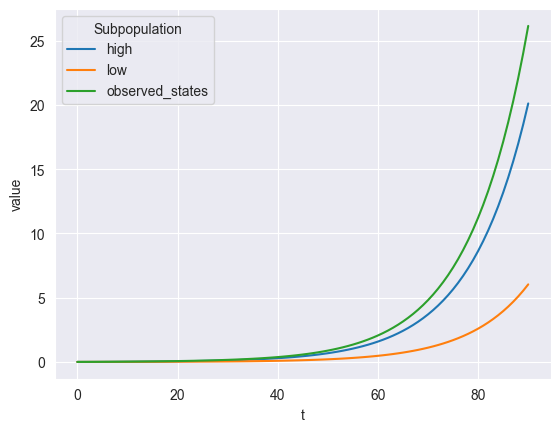

In [16]:
results_1_unstacked = unstack_results_and_plot_hospitalised(results_1)

We can find out the peak hospitilisations and total_hospitalisations using the code below.

In [17]:
hospitalised_records = [
    {'Scenario': 'Single infection at start',
     'Total hospitalisations': results_1.loc[90,('observed_states','H_cumulative')],
     'Peak hospitalisations': max(results_1.loc[:,('observed_states','H')]),
     }
]
pd.DataFrame.from_records(hospitalised_records)

,Scenario,Total hospitalisations,Peak hospitalisations
0,Single infection at start,87.891455,26.156877


# 2. Seeding at X proportion prevalence: MultinomialSeeder

MetaCast comes with a MultinomialSeeder for seeding infected population randomly drawing probabilities based time spent in compartments. In this example we will use MultinomialSeeder to seed our population with a chosen prevalence before running the model defined in the previous section.

## 2.1 Set up Seeders

For this we need to import metacast MultinomialSeeder

In [18]:
from metacast import MultnomialSeeder

Then we need to define a seeding information dictionary for MultinomialSeeder. This seeding information is a nested dictionary. The first level keys are the possible branches of your infecteds (infection course). The lowest level keys are the states with values being the rate at which people leave that state.

In [19]:
seeding_info = {'unhospitalised': {'E': 'sigma','I':'gamma'},
                'hospitalised': {'E': 'sigma','I':'gamma', 'H':'eta'},
                }
seeder = MultnomialSeeder(seeding_info)
seeder.set_seed(42) # This class uses random number generation (rng) use set_seed function to set rng seed.

## 2.2 Setup Populations with seeder

We can now random draws for our low and high risk population for a given prevalence.

In [20]:
prevelance = 0.01
low_risk_total_infected = low_risk_population*prevelance
low_risk_infected = seeder.seed_infections(n=low_risk_total_infected,
                                           branch_probability={'unhospitalised': 1- parameters['p_[low]'] ,'hospitalised': parameters['p_[low]']},
                                           parameters=parameters)
low_risk_infected

{'E': 2615, 'I': 6348, 'H': 37}

In [21]:
high_risk_total_infected = high_risk_population*prevelance
high_risk_infected = seeder.seed_infections(n=high_risk_total_infected,
                                            branch_probability={'unhospitalised': 1- parameters['p_[high]'] ,'hospitalised': parameters['p_[high]']},
                                            parameters=parameters)
high_risk_infected

{'E': 242, 'I': 665, 'H': 93}

Now we can use those draws in setting up our high and low risk populations.

In [22]:
y =np.zeros(metapop_model.total_states)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in state_index_dict_low.items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]

y

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.910e+05,
       2.615e+03, 6.348e+03, 3.700e+01, 0.000e+00, 0.000e+00, 0.000e+00])

In [23]:
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in state_index_dict_high.items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([9.900e+04, 2.420e+02, 6.650e+02, 9.300e+01, 0.000e+00, 8.910e+05,
       2.615e+03, 6.348e+03, 3.700e+01, 0.000e+00, 1.300e+02, 0.000e+00])

### 2.3 Run metapopulation model

The code below runs the model with our new starting population $y$.

In [24]:
results_seeded = metapop_model.integrate(y,t)
results_seeded

high                                                     \
               S           E            I           H             R   
0   99000.000000  242.000000   665.000000   93.000000      0.000000   
1   98801.058969  342.641615   668.445219  101.935645     85.918553   
2   98596.259944  419.884522   698.608886  109.958885    175.287763   
3   98380.446382  484.696450   746.559305  118.077852    270.220011   
4   98150.085623  543.577611   807.187224  126.854247    372.295295   
..           ...         ...          ...         ...           ...   
86  22665.762123  709.577451  2898.442819  856.912981  72869.304625   
87  22484.441196  662.333508  2725.410662  810.664871  73317.149764   
88  22315.317019  618.129171  2561.226073  766.257332  73739.070405   
89  22157.583553  576.787038  2405.627015  723.695206  74136.307187   
90  22010.485493  538.136919  2258.332363  682.971881  74510.073345   

              low                                                        \
                S            E             I           H              R   
0   891000.000000  2615.000000   6348.000000   37.000000       0.000000   
1   889209.530721  3396.898714   6445.661198   38.551195     909.358171   
2   887366.339498  4003.323975   6742.322752   40.090082    1847.923693   
3   885424.017439  4523.031362   7172.358337   41.828480    2838.764382   
4   883350.770609  5007.390448   7699.959965   43.876580    3898.002398   
..            ...          ...           ...         ...            ...   
86  203991.859107  6386.197061  26085.990582  257.074024  663278.879227   
87  202359.970762  5961.001575  24528.700468  243.199573  666907.127623   
88  200837.853171  5563.162540  23051.038574  229.877297  670318.068419   
89  199418.251981  5191.083346  21650.646525  217.108646  673522.909502   
90  198094.369437  4843.232269  20324.994206  204.891637  676532.512451   

   observed_states                
                 H  H_cumulative  
0       130.000000      0.000000  
1       140.486840     37.565353  
2       150.048967     76.184132  
3       159.906333    117.025288  
4       170.730827    160.893652  
..             ...           ...  
86     1113.987005  28724.954814  
87     1053.864444  28881.577662  
88      996.134628  29028.807778  
89      940.803852  29167.130899  
90      887.863518  29297.017609  

[91 rows x 12 columns]

### 2.4 Plotting hospitalisations

,Subpopulation,State,t,value
0,high,S,0,99000.000000
1,high,S,1,98801.058969
2,high,S,2,98596.259944
3,high,S,3,98380.446382
4,high,S,4,98150.085623
...,...,...,...,...
1087,observed_states,H_cumulative,86,28724.954814
1088,observed_states,H_cumulative,87,28881.577662
1089,observed_states,H_cumulative,88,29028.807778
1090,observed_states,H_cumulative,89,29167.130899


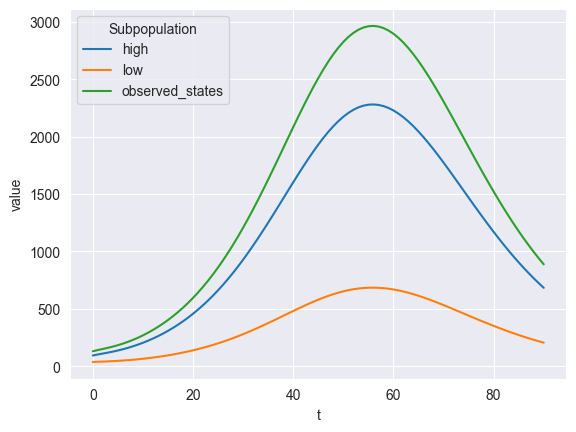

In [25]:
unstack_results_and_plot_hospitalised(results_seeded)

Let's compare with Total hospitalised and Peak Hospitalised from previous scenarios.

In [26]:
hospitalised_records.append(
    {'Scenario': 'Starting prevalence of ' + str(prevelance),
     'Total hospitalisations': results_seeded.loc[90,('observed_states','H_cumulative')],
     'Peak hospitalisations': max(results_seeded.loc[:,('observed_states','H')]),
     }
)
pd.DataFrame.from_records(hospitalised_records)

,Scenario,Total hospitalisations,Peak hospitalisations
0,Single infection at start,87.891455,26.156877
1,Starting prevalence of 0.01,29297.017609,2966.336876


# 3. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.

In this scenario we are going to assume that a new affordable rapid test for disease X has become available. Positive tests result in those in states $E$ or $I$ being moved to an isolating test positive population. For this scenario we will need to:
 * Extend our metapopulation dimensions for those who tested postive and negative.
  * Set up a MetaCast's event que with the new rapid pathogen test as a discrete event.

The equation for the model in this scenario very similar to the previous scenario's. The subscript $q$ has been added to denote those isolating (in quarantine) as the result of a positive test for disease X.
$$
    \frac{\delta S_{r,q}}{\delta t} = -\lambda_{r,q} S_{r,q}
$$
$$
    \frac{\delta E_{r,q}}{\delta t} = \lambda_{r,q} S_{r,q} - \sigma E_{r,q}
$$
$$
    \frac{\delta I_{r,q}}{\delta t} = \sigma E_{r,q} - \gamma I_{r,q}
$$
$$
    \frac{\delta H_{r,q}}{\delta t} = p_{r,q} \gamma I_{r,q} - \eta H_{r,q}
$$
$$
    \frac{\delta R_{r,q}}{\delta t} = (1-p_{r,q}) \gamma I_{r,q} + \eta H_{r,q}
$$
$$
    \lambda_{i} = \beta_{i} \sum_{j} \rho_{ij} I_j
$$


## 3.1 Change Population Structure

Lets start be changing the dimensions of our metapopulation by adding a new dimension for those who tested positive and those who tested negative.

In [27]:
isolation_groups = ['negative','positive']
rapid_pathogen_test_dimensions = [risk_groups,isolation_groups]

In [28]:
metapop_model.dimensions = rapid_pathogen_test_dimensions
metapop_model.dimensions

[{'high', 'low'}, {'negative', 'positive'}]

## 3.2 Set Population

We need to change our starting population as a result of the change in our metapopulation model's dimensions.

In [29]:
y =np.zeros(metapop_model.total_states)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in metapop_model.state_index[('low', 'negative')].items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in metapop_model.state_index[('high', 'negative')].items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([9.900e+04, 2.420e+02, 6.650e+02, 9.300e+01, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.910e+05, 2.615e+03,
       6.348e+03, 3.700e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.300e+02, 0.000e+00])

## 3.3 Set parameters

We also need to change our parameter values as a result of the change in our metapopulation model's dimensions.

In [30]:
metapop_model.parameter_names

['beta_[high,negative]',
 'beta_[high,positive]',
 'beta_[low,negative]',
 'beta_[low,positive]',
 'eta',
 'gamma',
 'p_[high,negative]',
 'p_[high,positive]',
 'p_[low,negative]',
 'p_[low,positive]',
 'rho_[high,negative]_[high,negative]',
 'rho_[high,negative]_[high,positive]',
 'rho_[high,negative]_[low,negative]',
 'rho_[high,negative]_[low,positive]',
 'rho_[high,positive]_[high,negative]',
 'rho_[high,positive]_[high,positive]',
 'rho_[high,positive]_[low,negative]',
 'rho_[high,positive]_[low,positive]',
 'rho_[low,negative]_[high,negative]',
 'rho_[low,negative]_[high,positive]',
 'rho_[low,negative]_[low,negative]',
 'rho_[low,negative]_[low,positive]',
 'rho_[low,positive]_[high,negative]',
 'rho_[low,positive]_[high,positive]',
 'rho_[low,positive]_[low,negative]',
 'rho_[low,positive]_[low,positive]',
 'sigma']

In [31]:
beta_parameters = {'beta' + subpop_suffix: beta for subpop_suffix in metapop_model.subpop_suffixes}
isolation_hospitalisation_probs = {
    **{'p_[high,'+ isolation_group +']': hospitalisation_probs['p_[high]'] for isolation_group in isolation_groups},
    **{'p_[low,'+ isolation_group +']': hospitalisation_probs['p_[low]'] for isolation_group in isolation_groups}
}

These new parameters need to account of the effect of isolation on the strength of transmission between populations $\rho_{ij}$.

In [32]:
transmission_reduction_from_isolation = 0.6
interaction_parameters = {
    **{'rho'+ subpop_suffix_i+'_['+risk_group +',negative]': rho
       for subpop_suffix_i in metapop_model.subpop_suffixes
       for risk_group in risk_groups},
    **{'rho'+ subpop_suffix_i+'_['+risk_group +',positive]': rho*(1-transmission_reduction_from_isolation)
       for subpop_suffix_i in metapop_model.subpop_suffixes
       for risk_group in risk_groups}
}
interaction_parameters

{'rho_[high,negative]_[low,negative]': 1,
 'rho_[high,negative]_[high,negative]': 1,
 'rho_[high,positive]_[low,negative]': 1,
 'rho_[high,positive]_[high,negative]': 1,
 'rho_[low,negative]_[low,negative]': 1,
 'rho_[low,negative]_[high,negative]': 1,
 'rho_[low,positive]_[low,negative]': 1,
 'rho_[low,positive]_[high,negative]': 1,
 'rho_[high,negative]_[low,positive]': 0.4,
 'rho_[high,negative]_[high,positive]': 0.4,
 'rho_[high,positive]_[low,positive]': 0.4,
 'rho_[high,positive]_[high,positive]': 0.4,
 'rho_[low,negative]_[low,positive]': 0.4,
 'rho_[low,negative]_[high,positive]': 0.4,
 'rho_[low,positive]_[low,positive]': 0.4,
 'rho_[low,positive]_[high,positive]': 0.4}

In [33]:
parameters = {**non_subpop_parameters,
              **isolation_hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
metapop_model.parameters = parameters

## 3.4 Set up Event Que

First we need to import the EventQueue and TransferEvent

In [34]:
from metacast.event_handling import EventQueue, TransferEvent

For those that would isolate if they comply with isolation order on a positive test we need the following:
 * The indexes of their current compartment (a from_index).
  * The index of the corresponding isolation compartment they would move to (a to_index).

In [35]:
from_index = [index
              for risk_group in risk_groups
              for state, index in metapop_model.state_index[(risk_group,'negative')].items()
              if state in ['E','I']]
to_index = [index
            for risk_group in risk_groups
            for state, index in metapop_model.state_index[(risk_group,'positive')].items()
            if state in ['E','I']]
display({'from index': from_index,'to index': to_index})

{'from index': [11, 12, 1, 2], 'to index': [16, 17, 6, 7]}

With our from_index and to_index we can set up a TransferEvent as our 'Rapid Pathogen Test'. The TransferEvent will also need:
 * A range of time at which to be triggered.
  * The proportion of population to move between the compartments in our from_index and to_index.
* A name.

In [36]:
test_every_x_days = 7
complaince = 0.8
test_sensitivity = 0.6
rapid_pathogen_test_event = TransferEvent(name='Rapid Pathogen Test',
                                          times= range(0,end_day+time_step,test_every_x_days),
                                          proportion= test_sensitivity*complaince,
                                          from_index= from_index,
                                          to_index= to_index)

With our 'Rapid Pathogen Test' set up we can set up our event que.

In [37]:
testing_eventqueue = EventQueue(rapid_pathogen_test_event)

**Note** you can setup the EventQueue with multiple event using a list. There are also more event types available than just the TransferEvent see [https://metacast.readthedocs.io/en/latest/autoapi/metacast/event_handling/events/index.html](https://metacast.readthedocs.io/en/latest/autoapi/metacast/event_handling/events/index.html).

## 3.5 Run simulations with Events

In order to run simulations using the EventQueue we need to give the run_sumulation method the following arguments:
* model_object : The object used to define and simulate model.
* run_attribute : The name of model_objects method that simulates model. Must return either a numpy array of pandas.DataFrame.
* y0 : A numpy.array storing the intial values of state varibles.
* end_time : The stop time of simulations.
* parameters_attribute : The name of the attribute of model_object that sets parameters (must accept dictionary where keys are strings and values are floats/ints).
* parameters : A dictionary {str : floats/ints} defining the model parameters.

Start_time and simulation_step (simulation time step) are optional. If not given the will be set at default values (start_time=0 and simulation_step=1).

In [38]:
results_rapid_test, transfer_df = testing_eventqueue.run_simulation(model_object=metapop_model,
                                                                    run_attribute='integrate',
                                                                    parameters=parameters,
                                                                    parameters_attribute='parameters',
                                                                    y0=y,
                                                                    end_time=end_day,
                                                                    start_time=0,
                                                                    simulation_step=time_step)
results_rapid_test

high,negative                                                      \
               S            E            I           H             R   
0   99000.000000   125.840000   345.800000   93.000000      0.000000   
1   98858.312671   210.705027   353.029103   89.631414     52.961785   
2   98712.363615   275.243698   382.133686   87.625093    107.273909   
3   98558.458366   328.324236   425.413048   87.416233    165.028117   
4   98394.046814   375.343778   478.347040   89.131034    227.771335   
..           ...          ...          ...         ...           ...   
86  62790.008838   950.234242  1379.858724  363.593632  16079.722154   
87  62386.007034  1024.590255  1503.625315  353.744803  16295.450183   
88  61975.422182  1083.472484  1631.412575  350.587928  16522.522422   
89  61558.124567  1131.372813  1758.636902  352.967216  16762.316091   
90  61134.148693  1171.371848  1882.481759  359.796138  17015.619152   

   high,positive                                                     ...  \
               S           E            I           H             R  ...   
0            0.0  116.160000   319.200000    0.000000      0.000000  ...   
1            0.0   83.232277   307.269880   12.189229     32.668613  ...   
2            0.0   59.638532   288.264424   21.550242     65.906802  ...   
3            0.0   42.732876   265.581346   28.393472     98.652306  ...   
4            0.0   30.619443   241.469899   33.080678    130.189980  ...   
..           ...         ...          ...         ...           ...  ...   
86           0.0  385.534079  2135.797612  425.583078  15489.667641  ...   
87           0.0  276.247236  1952.912288  427.762209  15779.660678  ...   
88           0.0  197.939794  1765.618954  422.318692  16050.704970  ...   
89           0.0  141.830058  1582.655306  410.651870  16301.445176  ...   
90           0.0  101.625676  1409.285325  394.172841  16531.498568  ...   

    low,negative                            low,positive               \
               I           H              R            S            E   
0    3300.960000   37.000000       0.000000          0.0  1255.200000   
1    3400.682123   34.610301     478.483718          0.0   899.390102   
2    3675.721416   32.908742     983.995122          0.0   644.441167   
3    4064.446218   31.952744    1536.720698          0.0   461.762273   
4    4531.466337   31.728538    2150.149989          0.0   330.867125   
..           ...         ...            ...          ...          ...   
86  12418.728516  109.078091  147377.069805          0.0  3469.806712   
87  13532.627832  106.123442  149232.937255          0.0  2486.225124   
88  14682.713173  105.176379  151249.122587          0.0  1781.458146   
89  15827.732121  105.890166  153427.965423          0.0  1276.470525   
90  16942.335831  107.938842  155767.104590          0.0   914.631085   

                                            observed_states                
               I           H              R               H  H_cumulative  
0    3047.040000    0.000000       0.000000      130.000000      0.000000  
1    2971.662951    3.906394     427.280553      140.337339     37.408122  
2    2812.704350    6.946274     838.148208      149.030351     75.056797  
3    2607.827922    9.195292    1223.454513      156.957741    113.590271  
4    2382.161064   10.755282    1578.456529      164.695532    153.492811  
..           ...         ...            ...             ...           ...  
86  19222.183714  127.675051  143613.270394     1025.929852  12591.570885  
87  17576.215101  128.328774  146242.166874     1015.959228  12785.810925  
88  15890.574500  126.695704  148634.207522     1004.778703  12976.722225  
89  14243.901147  123.195645  150789.368555      992.704896  13164.408304  
90  12683.570866  118.251925  152716.481996      980.159747  13349.153783  

[91 rows x 22 columns]

As well as a pandas.DataFrame giving results of the simulation the run_simulation method return a transfer_df DataFrame outlineing the details of events that transferred populations between compartments. This can be handy in debugging or scenario analyses.

In [39]:
transfer_df

,time,transfered,event
0,0,4737.600000,Rapid Pathogen Test
1,7,5771.394164,Rapid Pathogen Test
2,14,7270.076042,Rapid Pathogen Test
3,21,9202.865995,Rapid Pathogen Test
4,28,11450.978415,Rapid Pathogen Test
5,35,13878.747039,Rapid Pathogen Test
6,42,16283.568927,Rapid Pathogen Test
7,49,18396.193990,Rapid Pathogen Test
8,56,19925.821613,Rapid Pathogen Test
9,63,20635.967504,Rapid Pathogen Test


### 3.6 Plotting hospitalisations

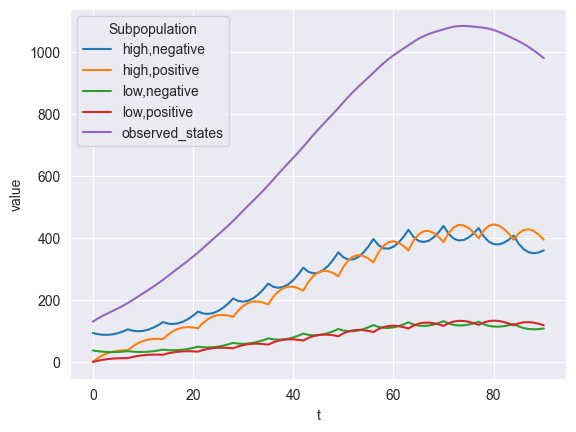

In [40]:
results_rapid_test_unstacked = unstack_results_and_plot_hospitalised(results_rapid_test)

Let's compare with Total hospitalised and Peak Hospitalised from previous scenarios.

In [41]:
hospitalised_records.append(
    {'Scenario': 'Tests every ' + str(test_every_x_days) + ' day resulting in ' + str(complaince*test_sensitivity) + ' in isolation ('+
                 str(1-transmission_reduction_from_isolation) + ' transmission).',
     'Total hospitalisations': results_rapid_test.loc[90,('observed_states','H_cumulative')],
     'Peak hospitalisations': max(results_rapid_test.loc[:,('observed_states','H')])
     }
)
pd.DataFrame.from_records(hospitalised_records)

,Scenario,Total hospitalisations,Peak hospitalisations
0,Single infection at start,87.891455,26.156877
1,Starting prevalence of 0.01,29297.017609,2966.336876
2,Tests every 7 day resulting in 0.48 in isolati...,13349.153783,1083.910371


## 3.6 Comparing with Rapid test event turned to null (do nothing) event.

In testing the code MetaCaster was developed from [(Grunnill et al. 2024)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011018) we found that the precision of Scipy's odeint could vary when running many events in an event queue. Scipy odeint being the underlying function for MetaCaster's integrate function. Therefore, we added an easy way to make events do nothing, a make_event_a_nullevent method, to check for differences due to odeint differing precision.

Let check that such differences odeint's precision have not crept. To do this we will compare eventque simulation with rapid_pathogen_test_event set to do nothing with simulations from section 2.

In [42]:
rapid_pathogen_test_event.make_event_a_nullevent()
results_rapid_test_null, transfer_df = testing_eventqueue.run_simulation(model_object=metapop_model,
                                                                         run_attribute='integrate',
                                                                         parameters=parameters,
                                                                         parameters_attribute='parameters',
                                                                         y0=y,
                                                                         end_time=end_day,
                                                                         start_time=0,
                                                                         simulation_step=time_step)
results_rapid_test_null

high,negative                                                     \
               S           E            I           H             R   
0   99000.000000  242.000000   665.000000   93.000000      0.000000   
1   98801.058969  342.641615   668.445219  101.935645     85.918553   
2   98596.259944  419.884522   698.608886  109.958885    175.287763   
3   98380.446382  484.696450   746.559305  118.077852    270.220011   
4   98150.085623  543.577611   807.187224  126.854247    372.295295   
..           ...         ...          ...         ...           ...   
86  22665.763550  709.577503  2898.442877  856.912960  72869.303111   
87  22484.442605  662.333560  2725.410738  810.664857  73317.148239   
88  22315.318411  618.129223  2561.226163  766.257325  73739.068877   
89  22157.584932  576.787089  2405.627109  723.695204  74136.305665   
90  22010.486856  538.136969  2258.332465  682.971883  74510.071827   

   high,positive                      ...  low,negative              \
               S    E    I    H    R  ...             I           H   
0            0.0  0.0  0.0  0.0  0.0  ...   6348.000000   37.000000   
1            0.0  0.0  0.0  0.0  0.0  ...   6445.661198   38.551195   
2            0.0  0.0  0.0  0.0  0.0  ...   6742.322752   40.090082   
3            0.0  0.0  0.0  0.0  0.0  ...   7172.358337   41.828480   
4            0.0  0.0  0.0  0.0  0.0  ...   7699.959965   43.876580   
..           ...  ...  ...  ...  ...  ...           ...         ...   
86           0.0  0.0  0.0  0.0  0.0  ...  26085.991099  257.074017   
87           0.0  0.0  0.0  0.0  0.0  ...  24528.701160  243.199569   
88           0.0  0.0  0.0  0.0  0.0  ...  23051.039379  229.877295   
89           0.0  0.0  0.0  0.0  0.0  ...  21650.647374  217.108645   
90           0.0  0.0  0.0  0.0  0.0  ...  20324.995124  204.891638   

                  low,positive                     observed_states  \
                R            S    E    I    H    R               H   
0        0.000000          0.0  0.0  0.0  0.0  0.0      130.000000   
1      909.358171          0.0  0.0  0.0  0.0  0.0      140.486840   
2     1847.923693          0.0  0.0  0.0  0.0  0.0      150.048967   
3     2838.764382          0.0  0.0  0.0  0.0  0.0      159.906333   
4     3898.002398          0.0  0.0  0.0  0.0  0.0      170.730827   
..            ...          ...  ...  ...  ...  ...             ...   
86  663278.865412          0.0  0.0  0.0  0.0  0.0     1113.986977   
87  666907.113780          0.0  0.0  0.0  0.0  0.0     1053.864426   
88  670318.054615          0.0  0.0  0.0  0.0  0.0      996.134620   
89  673522.895787          0.0  0.0  0.0  0.0  0.0      940.803849   
90  676532.498815          0.0  0.0  0.0  0.0  0.0      887.863521   

                  
    H_cumulative  
0       0.000000  
1      37.565353  
2      76.184132  
3     117.025288  
4     160.893652  
..           ...  
86  28724.954215  
87  28881.577062  
88  29028.807180  
89  29167.130305  
90  29297.017018  

[91 rows x 22 columns]

In [43]:
transfer_df

,time,transfered,event
0,0,None,Rapid Pathogen Test
1,7,None,Rapid Pathogen Test
2,14,None,Rapid Pathogen Test
3,21,None,Rapid Pathogen Test
4,28,None,Rapid Pathogen Test
5,35,None,Rapid Pathogen Test
6,42,None,Rapid Pathogen Test
7,49,None,Rapid Pathogen Test
8,56,None,Rapid Pathogen Test
9,63,None,Rapid Pathogen Test


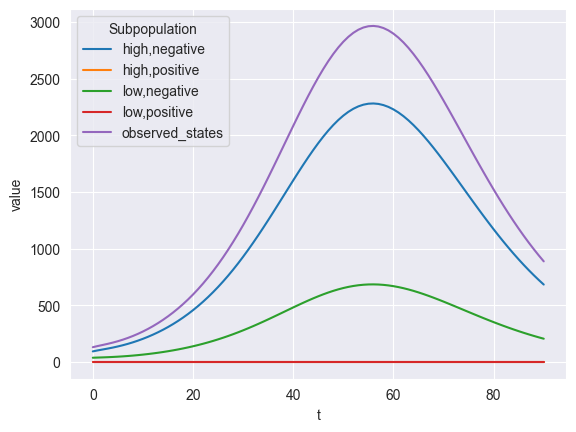

In [44]:
results_rapid_test_null_unstacked = unstack_results_and_plot_hospitalised(results_rapid_test_null)

Let's compare with Total hospitalised and Peak Hospitalised from previous scenarios.

In [45]:
hospitalised_records.append(
    {'Scenario': 'Do nothing event.',
     'Total hospitalisations': results_rapid_test_null.loc[90,('observed_states','H_cumulative')],
     'Peak hospitalisations': max(results_rapid_test_null.loc[:,('observed_states','H')])
     }
)
pd.DataFrame.from_records(hospitalised_records)

,Scenario,Total hospitalisations,Peak hospitalisations
0,Single infection at start,87.891455,26.156877
1,Starting prevalence of 0.01,29297.017609,2966.336876
2,Tests every 7 day resulting in 0.48 in isolati...,13349.153783,1083.910371
3,Do nothing event.,29297.017018,2966.336857


As we can see there is no differences caused by a change in odeint's precision. If there were we would have to compare our 'Tests every 7 day resulting in 0.48 in isolation (0.4 transmission)' scenario to the 'Do nothing event'.

# 4. New Vaccine: Multi Dimension/Axis disease X model with flows between some subpopulations.

In this scenario we will be looking at the deployment of a new vaccine that has become available for disease X. This new vaccine is not completely transmission blocking, but does at least provide some protection against hospitalisations in breakthrough infections. We will therefore be replacing the second dimension in our previous model from 'negative' and 'positive' to 'unvaccinated', 'vaccination_lag' and 'vaccinated'. We will also setup flows of population between these dimensions 'unvaccinated'->'vaccination_lag'->'vaccinated'.

The equation for the model in this scenario have changed a bit from the previous scenario's. The subscript $v$ replaces $q$ to denote 'unvaccinated', 'vaccination_lag' and 'vaccinated' groups.

$$
    \frac{\delta S_{r,v}}{\delta t} = \nu_{v-1} S_{r,v-1} - \lambda_{r,v} S_{r,v} - \nu_{v} S_{r,v}
$$
$$
    \frac{\delta E_{r,v}}{\delta t} = \nu_{v-1} E_{r,v-1} + \lambda_{r,v} S_{r,v} - \sigma E_{r,v} - \nu_{v} E_{r,v}
$$
$$
    \frac{\delta I_{r,v}}{\delta t} = \nu_{v-1} I_{r,v-1} + \sigma E_{r,v} - \gamma I_{r,v} - \nu_{v} I_{r,v}
$$
$$
    \frac{\delta H_{r,v}}{\delta t} = \nu_{v-1} H_{r,v-1} + p_{r,v} \gamma I_{r,v} - \eta H_{r,v} - \nu_{v} H_{r,v}
$$
$$
    \frac{\delta R_{r,v}}{\delta t} = \nu_{v-1} R_{r,v-1} + (1-p_{r,v}) \gamma I_{r,v} + \eta H_{r,v} - \nu_{v} R_{r,v}
$$
$$
    \lambda_{i} = \beta_{i} \sum_{j} \rho_{ij} I_j
$$

For our vaccinated populations $\beta_{r,v=vaccinated}=\beta(1-l_v)$ and $p_{r,v=vaccinated}=p_{r}(1-h_v)$. Were $l_v$ is vaccine's effectiveness in decreasing susceptibility and $h_v$ is the vaccines effectiveness in preventing hospitalizing infections.

## 4.1 Set metapopulation dimensions using a list of subpopulation transfer dictionaries.

With flows of population (unvaccinated'->'vaccination_lag'->'vaccinated') we need to define our metapopulation model dimensions differently than in previous scenarios. This time we will define dimensions using a list transfer dictionaries. These transfer dictionaries outline the flow between one subpopulation and another. Each transfer dictionary should contain:

* from_coordinates:  Subpopulation coordinates from which hosts are leaving. All of these entries should be of the same length.
* to_coordinates:  Subpopulation coordinates from which hosts are leaving. All of these entries should be of the same length and the same length as the from_coordinates entries.
* states: Host states which will transition between subpopulations. Single entry of 'all' value means all the available model states transition between subpopulations. Alternatively a list of specific states can be given.
* parameter : Name given to parameter that is responsible for flow of hosts transferring between subpopulations.

In [46]:
vaccination_groups = ['unvaccinated','vaccination_lag' 'vaccinated']
vaccination_transfers = [{'from_coordinates': (risk_group,'unvaccinated'),
                          'to_coordinates': (risk_group,'vaccination_lag'),
                          'states': 'all', 'parameter': 'nu_unvaccinated'}
                         for risk_group in risk_groups]
vacination_lag_transfers = [{'from_coordinates': (risk_group,'vaccination_lag'),
                             'to_coordinates': (risk_group,'vaccinated'),
                             'states': 'all', 'parameter': 'nu_vaccination_lag'}
                            for risk_group in risk_groups]

vaccination_dimensions = vaccination_transfers + vacination_lag_transfers
vaccination_dimensions

[{'from_coordinates': ('low', 'unvaccinated'),
  'to_coordinates': ('low', 'vaccination_lag'),
  'states': 'all',
  'parameter': 'nu_unvaccinated'},
 {'from_coordinates': ('high', 'unvaccinated'),
  'to_coordinates': ('high', 'vaccination_lag'),
  'states': 'all',
  'parameter': 'nu_unvaccinated'},
 {'from_coordinates': ('low', 'vaccination_lag'),
  'to_coordinates': ('low', 'vaccinated'),
  'states': 'all',
  'parameter': 'nu_vaccination_lag'},
 {'from_coordinates': ('high', 'vaccination_lag'),
  'to_coordinates': ('high', 'vaccinated'),
  'states': 'all',
  'parameter': 'nu_vaccination_lag'}]

In [47]:
metapop_model.dimensions = vaccination_dimensions
metapop_model.dimensions

[{'high', 'low'}, {'unvaccinated', 'vaccinated', 'vaccination_lag'}]

## 4.2 Set population

We need to change our starting population as a result of the change in our metapopulation model’s dimensions.

In [48]:
metapop_model.total_states

32

In [49]:
y = np.zeros(metapop_model.total_states)

for state, index in metapop_model.state_index[('high','unvaccinated')].items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

for state, index in metapop_model.state_index[('low','unvaccinated')].items():
    if state in low_risk_state_pops:
        y[index] =low_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([9.900e+04, 2.420e+02, 6.650e+02, 9.300e+01, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 8.910e+05, 2.615e+03, 6.348e+03,
       3.700e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.300e+02, 0.000e+00])

## 4.3 Set parameters

We also need to change our parameter values as a result of the change in our metapopulation model's dimensions.

In [50]:
metapop_model.parameter_names

['beta_[high,unvaccinated]',
 'beta_[high,vaccinated]',
 'beta_[high,vaccination_lag]',
 'beta_[low,unvaccinated]',
 'beta_[low,vaccinated]',
 'beta_[low,vaccination_lag]',
 'eta',
 'gamma',
 'nu_unvaccinated',
 'nu_vaccination_lag',
 'p_[high,unvaccinated]',
 'p_[high,vaccinated]',
 'p_[high,vaccination_lag]',
 'p_[low,unvaccinated]',
 'p_[low,vaccinated]',
 'p_[low,vaccination_lag]',
 'rho_[high,unvaccinated]_[high,unvaccinated]',
 'rho_[high,unvaccinated]_[high,vaccinated]',
 'rho_[high,unvaccinated]_[high,vaccination_lag]',
 'rho_[high,unvaccinated]_[low,unvaccinated]',
 'rho_[high,unvaccinated]_[low,vaccinated]',
 'rho_[high,unvaccinated]_[low,vaccination_lag]',
 'rho_[high,vaccinated]_[high,unvaccinated]',
 'rho_[high,vaccinated]_[high,vaccinated]',
 'rho_[high,vaccinated]_[high,vaccination_lag]',
 'rho_[high,vaccinated]_[low,unvaccinated]',
 'rho_[high,vaccinated]_[low,vaccinated]',
 'rho_[high,vaccinated]_[low,vaccination_lag]',
 'rho_[high,vaccination_lag]_[high,unvaccinated]'

This time around we are going to setup a function for setting up the parameters as we will be using the same metapopulation model in the next exercise.

In [51]:
def vaccination_parameters_setup(nu_unvaccinated,
                                 nu_vaccination_lag,
                                 l_v,
                                 h_v,
                                 other_parameters,
                                 metapop_model):
    parameters = {key: value for key, value in other_parameters.items() if key in metapop_model.parameter_names}
    parameters.update({'nu_unvaccinated': nu_unvaccinated,
                       'nu_vaccination_lag': nu_vaccination_lag})

    beta = other_parameters['beta']
    parameters.update({'beta_[high,unvaccinated]': beta,
                       'beta_[high,vaccinated]': beta*(1-l_v),
                       'beta_[high,vaccination_lag]': beta,
                       'beta_[low,unvaccinated]': beta,
                       'beta_[low,vaccinated]': beta*(1-l_v),
                       'beta_[low,vaccination_lag]': beta})

    if h_v < l_v:
        raise ValueError('h_v must be greater than or equal to l_v. ' +
                         'Otherwise vaccine reduced severity given reduced susceptibility is negative.')

    vaccine_reduced_severity_given_reduced_susceptibility = 1-((1-h_v)/(1-l_v))
    p_high = other_parameters['p_[high]']
    p_low = other_parameters['p_[low]']
    parameters.update({'p_[high,unvaccinated]': p_high,
                       'p_[high,vaccinated]': p_high*(1-vaccine_reduced_severity_given_reduced_susceptibility),
                       'p_[high,vaccination_lag]': p_high,
                       'p_[low,unvaccinated]': p_low,
                       'p_[low,vaccinated]': p_low*(1-vaccine_reduced_severity_given_reduced_susceptibility),
                       'p_[low,vaccination_lag]': p_low})
    rho = other_parameters['rho']
    parameters.update({'rho'+ subpop_suffix_i+subpop_suffix_j: rho
                       for subpop_suffix_i in metapop_model.subpop_suffixes
                       for subpop_suffix_j in metapop_model.subpop_suffixes})
    return parameters

def prob_over_many_days_to_prob_on_a_day(prob, many_days):
    return 1-(1-prob)**(1/many_days)

In [52]:
v_day = end_day
prob_vaccinated_by_v_day = 0.7
prob_vaccinated_per_day = prob_over_many_days_to_prob_on_a_day(prob_vaccinated_by_v_day ,v_day)
vaccination_lag = 1/14
vaccine_reduced_susceptibility = 0.4
vaccine_reduced_severity = 0.8
other_parameters = {'beta':beta, 'rho': rho, **non_subpop_parameters, **hospitalisation_probs}
parameters = vaccination_parameters_setup(nu_unvaccinated=prob_vaccinated_per_day*complaince,
                                          nu_vaccination_lag=vaccination_lag,
                                          l_v=vaccine_reduced_susceptibility,
                                          h_v=vaccine_reduced_severity,
                                          other_parameters=other_parameters,
                                          metapop_model=metapop_model)
parameters

{'eta': 0.2,
 'gamma': 0.14285714285714285,
 'sigma': 0.3333333333333333,
 'nu_unvaccinated': 0.010630715875610531,
 'nu_vaccination_lag': 0.07142857142857142,
 'beta_[high,unvaccinated]': 2.857142857142857e-07,
 'beta_[high,vaccinated]': 1.714285714285714e-07,
 'beta_[high,vaccination_lag]': 2.857142857142857e-07,
 'beta_[low,unvaccinated]': 2.857142857142857e-07,
 'beta_[low,vaccinated]': 1.714285714285714e-07,
 'beta_[low,vaccination_lag]': 2.857142857142857e-07,
 'p_[high,unvaccinated]': 0.3,
 'p_[high,vaccinated]': 0.09999999999999998,
 'p_[high,vaccination_lag]': 0.3,
 'p_[low,unvaccinated]': 0.01,
 'p_[low,vaccinated]': 0.0033333333333333327,
 'p_[low,vaccination_lag]': 0.01,
 'rho_[high,unvaccinated]_[high,unvaccinated]': 1,
 'rho_[high,unvaccinated]_[high,vaccination_lag]': 1,
 'rho_[high,unvaccinated]_[high,vaccinated]': 1,
 'rho_[high,unvaccinated]_[low,unvaccinated]': 1,
 'rho_[high,unvaccinated]_[low,vaccination_lag]': 1,
 'rho_[high,unvaccinated]_[low,vaccinated]': 1,
 'r

In [53]:
metapop_model.parameters = parameters

### 4.4 Run metapopulation model

Lets run our model.

In [54]:
results_vaccination = metapop_model.integrate(y,t)
results_vaccination

high,unvaccinated                                                     \
                   S           E            I           H             R   
0       99000.000000  242.000000   665.000000   93.000000      0.000000   
1       97756.296153  339.018342   661.376802  100.857736     85.010015   
2       96522.091595  411.050280   683.912127  107.645679    171.600230   
3       95292.395742  469.474741   723.124343  114.371489    261.738029   
4       94063.991005  520.919026   773.576642  121.572975    356.795713   
..               ...         ...          ...         ...           ...   
86      11156.243479  319.413087  1205.324487  341.966702  27059.102947   
87      10954.991682  297.149119  1128.955720  322.056008  26955.054155   
88      10761.759913  276.362796  1056.809998  303.060618  26840.851241   
89      10576.060646  256.966008   988.728981  284.966737  26717.194582   
90      10397.437267  238.874412   924.550228  267.756985  26584.758065   

   high,vaccination_lag                                                 ...  \
                      S          E           I          H            R  ...   
0              0.000000   0.000000    0.000000   0.000000     0.000000  ...   
1           1008.258865   3.496637    6.821443   1.040247     0.876794  ...   
2           1932.335701   8.229071   13.691662   2.155026     3.435372  ...   
3           2778.034141  13.686474   21.081054   3.334242     7.630380  ...   
4           3550.644909  19.663194   29.200292   4.589030    13.468011  ...   
..                  ...        ...         ...        ...          ...  ...   
86          1940.250227  55.551075  209.625320  59.473511  4706.013342  ...   
87          1905.855034  51.695443  196.405986  56.028529  4689.408003  ...   
88          1872.798184  48.093597  183.909682  52.739643  4670.936527  ...   
89          1840.999990  44.730683  172.110401  49.604837  4650.725504  ...   
90          1810.385645  41.592442  160.981251  46.621431  4628.896831  ...   

   low,vaccination_lag                          low,vaccinated               \
                     I          H             R              S            E   
0             0.000000   0.000000      0.000000       0.000000     0.000000   
1            65.777585   0.393413      9.279945     328.625034     1.172928   
2           132.139177   0.785704     36.216473    1277.222209     5.146925   
3           202.530310   1.181138     80.160051    2792.695849    12.294483   
4           278.548981   1.587262    141.012607    4825.379048    22.857622   
..                 ...        ...           ...            ...          ...   
86         1886.628244  17.842062  42871.539254  180021.043175  3105.571365   
87         1767.654185  16.808566  42692.119907  180438.267087  2949.905974   
88         1655.187406  15.821900  42497.263366  180876.092482  2800.422774   
89         1548.993842  14.881457  42288.091377  181333.531985  2657.052146   
90         1448.831458  13.986434  42065.677724  181809.589256  2519.701561   

                                           observed_states                
               I          H              R               H  H_cumulative  
0       0.000000   0.000000       0.000000      130.000000      0.000000  
1       2.374709   0.013523       0.336504      140.483874     37.562238  
2       9.600054   0.052118       2.658028      150.026145     76.158995  
3      22.137725   0.113463       8.922767      159.830780    116.938267  
4      40.634474   0.196318      21.145372      170.552785    160.679762  
..           ...        ...            ...             ...           ...  
86  11783.171161  42.955397  281570.581310      708.012288  20528.822545  
87  11275.790906  41.261127  286276.377811      670.308074  20628.925326  
88  10780.890097  39.592411  290897.102454      634.107418  20723.141166  
89  10299.142526  37.953171  295433.524857      599.406757  20811.766997  
90   9831.091057  36.346834  299886.580279      566.194859  20895.09058

### 4.5 Plotting hospitalisations

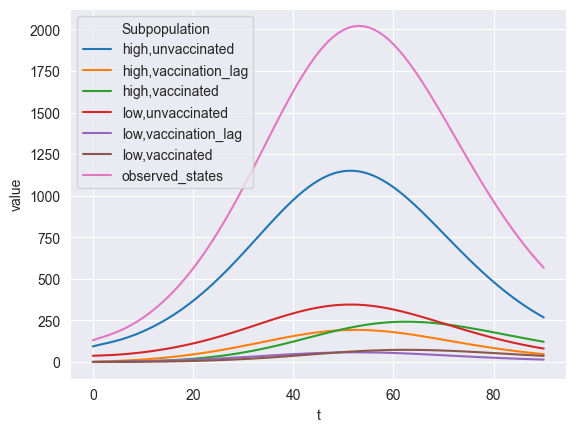

In [55]:
results_vaccination_unstacked = unstack_results_and_plot_hospitalised(results_vaccination)

Let's compare with Total hospitalised and Peak Hospitalised from previous scenarios.

In [56]:
hospitalised_records.append(
    {'Scenario': 'Vaccinating ' + str(prob_vaccinated_by_v_day) + ' population by day '+ str(v_day),
     'Total hospitalisations': results_vaccination.loc[90,('observed_states','H_cumulative')],
     'Peak hospitalisations': max(results_vaccination.loc[:,('observed_states','H')])
     }
)
hospitalised_results_df = pd.DataFrame.from_records(hospitalised_records)
hospitalised_results_df

,Scenario,Total hospitalisations,Peak hospitalisations
0,Single infection at start,87.891455,26.156877
1,Starting prevalence of 0.01,29297.017609,2966.336876
2,Tests every 7 day resulting in 0.48 in isolati...,13349.153783,1083.910371
3,Do nothing event.,29297.017018,2966.336857
4,Vaccinating 0.7 population by day 90,20895.090581,2020.866274


# 5. New Vaccine's Efficacy is Uncertain: Latin Hypercube Sampling in simulation of a 2 dimensional disease X model.

Some uncertainties have come about in the new vaccine for disease X, both in terms of efficacy and delivery. Therefore, in this next exercise we will running a sensitivity analyses of the metapopulation model from the previous scenario using Latin Hypercube Sampling. For a description of Latin Hypercube Sampling (LHS) and Partial Rank Correlation Coefficients I suggest you read [Marino et, al. (2008)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2570191/).

For generating an LH sample, running simulations for all of the parameter sets in the LH sample we will need to import MetaCast's lhs_prcc function.

In [57]:
from metacast.sensitivity_analyses import lhs_prcc

## 5.1 Setup a function for running the metapopulation model.

lhs_prcc in tangent with a user defined function that sets up the model and runs a sampled parameter set. Key features of this user defined function are:
* The first argument of this function must be for a dictionary of the sampled parameters.
* The returned object must be a dictionary combining the first argument of input parameters with the results you wished to see from the simulation.

**Note** we will see later that lhs_prcc can pass other key word arguments (kwargs) to this user defined function.

Lets create such a function for running our vaccination model below.

In [58]:
def vaccination_lhs_sim(sample, # First argument must be for a dictionary of the sampled parameters
                        t,
                        y0,
                        fixed_parameter,
                        metapop_model):
    parameters = vaccination_parameters_setup(**sample, other_parameters=fixed_parameter,
                                              metapop_model=metapop_model)
    metapop_model.parameters = parameters
    results = metapop_model.integrate(y0, t)
    focused_results = {'Total hospitalisations': results.loc[90, ('observed_states', 'H_cumulative')],
                       'Peak hospitalisations': max(results.loc[:, ('observed_states', 'H')])}
    results_and_sample = sample | focused_results #
    return results_and_sample

## 5.2 Setup parameter ranges to sample from.

In order to generate a LH sample `lhs_prcc` requires a pandas.DataFrame outlining the bombardiers of LHS (our parameter certainties). **Note** currently metacast only support latin hypercube sampling with uniform distributions. Key features of this DataFrame:
* Must contain fields 'Lower Bound' and 'Upper Bound'.
* The name of the parameters is assumed to be in the index of the DataFrame.

The code below creates such a DataFrame outlining certainties surrounding disease X's vaccination parameters.

In [59]:
parameter_samples_records = [
    {'parameter': 'nu_unvaccinated',
     'Lower Bound': prob_over_many_days_to_prob_on_a_day(0.5, v_day),
     'Upper Bound': prob_over_many_days_to_prob_on_a_day(0.95, v_day)}, # Rate of vaccinations.

    {'parameter': 'nu_vaccination_lag', 'Lower Bound': 1/28, 'Upper Bound': 1/7}, # Lag between vaccination and vaccination being effective.
    {'parameter': 'l_v', 'Lower Bound': 0.3, 'Upper Bound': 0.6}, # Reduction in susceptibility to disease X after vaccination.
    {'parameter': 'h_v', 'Lower Bound': 0.7, 'Upper Bound': 0.95} # Reduction in hospitalisation with disease X after vaccination.
]
parameter_samples_df = pd.DataFrame.from_records(parameter_samples_records)
parameter_samples_df.set_index('parameter',inplace=True) # The parameters must be set as the index of the dataframe.
parameter_samples_df

,Lower Bound,Upper Bound
parameter,,
nu_unvaccinated,0.007672,0.032738
nu_vaccination_lag,0.035714,0.142857
l_v,0.300000,0.600000
h_v,0.700000,0.950000


##  5.3 Run simulations with LHS

 Let's test run `lhs_prcc` with a small sample size. As well as the DataFrame outlineing the sampling of parameters and our user defined function for running our model, `lhs_prcc` requires the number of samples generated in the LHS. All other arguments in the code cell below are passed to the function for running our model.

In [60]:
results_and_sample_df, prccs = lhs_prcc(parameters_df=parameter_samples_df,
                                        sample_size=10,
                                        model_run_method=vaccination_lhs_sim,
                                        metapop_model=metapop_model,
                                        t=t,
                                        y0=y,
                                        fixed_parameter=other_parameters)
results_and_sample_df

Simulating LH Sample:   0%|          | 0/10 [00:00<?, ?it/s]

,nu_unvaccinated,nu_vaccination_lag,l_v,h_v,Total hospitalisations,Peak hospitalisations
0,0.017426,0.051832,0.417117,0.711032,19739.172903,1881.113191
1,0.018719,0.113533,0.344348,0.744192,16760.481745,1541.937922
2,0.007717,0.095371,0.426047,0.825587,21933.217613,2126.644631
3,0.010409,0.133134,0.472948,0.928956,17882.010753,1693.324150
4,0.020365,0.110219,0.593317,0.855814,12656.611105,1151.807108
5,0.029221,0.043742,0.495347,0.905433,13555.871482,1298.154348
6,0.027326,0.061399,0.552683,0.816773,13370.066309,1237.590949
7,0.031277,0.071587,0.511075,0.761115,12872.623556,1156.972186
8,0.025167,0.131434,0.315596,0.795752,13432.852396,1200.196471
9,0.012864,0.084452,0.380343,0.883671,18199.662815,1745.216823


As well as a dataframe of results and sampled parameters `lhs_prcc` performs analyses the ranked correlation between parameters and results. This form of rank correlation coefficent adjusts for the effect of other paramters [(Marino et, al. 2008)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2570191/). The results partial rank correlation coefficient analyses are pictured below.

In [61]:
prccs

,n,r,p-val,Number_of_Covariables,lower_CI_0.95,upper_CI_0.95
h_v on Peak hospitalisations,10,0.108450,0.816970,3,-0.70,0.80
h_v on Total hospitalisations,10,0.199380,0.668209,3,-0.65,0.83
l_v on Peak hospitalisations,10,-0.697856,0.081248,3,-0.95,0.12
l_v on Total hospitalisations,10,-0.814221,0.025781,3,-0.97,-0.16
nu_unvaccinated on Peak hospitalisations,10,-0.936091,0.001916,3,-0.99,-0.62
nu_unvaccinated on Total hospitalisations,10,-0.938737,0.001726,3,-0.99,-0.63
nu_vaccination_lag on Peak hospitalisations,10,-0.880966,0.008798,3,-0.98,-0.38
nu_vaccination_lag on Total hospitalisations,10,-0.879153,0.009127,3,-0.98,-0.37


Our initial sample size is quite small. We may need to run a much larger sample size. To do so in serially would take a long time. Luckily `lhs_prcc` can take a `dask.distributed.Client` for running simulations in parallel.

##  5.4 Run simulations with LHS in parallel

First we will need to know the number of cores on the macine we are using. It is best practice to not run use all your machines' cores as this will make running other programs difficult.

In [62]:
import os
number_cpu = os.cpu_count()
number_cpu

20

Then we need to setup a dask Client.

In [63]:
# setup the dask cluster
import dask

client = dask.distributed.Client(n_workers=number_cpu-1, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 19
Total threads: 19,Total memory: 15.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58168,Workers: 19
Dashboard: http://127.0.0.1:8787/status,Total threads: 19
Started: Just now,Total memory: 15.69 GiB
Comm: tcp://127.0.0.1:58263,Total threads: 1
Dashboard: http://127.0.0.1:58267/status,Memory: 845.72 MiB
Nanny: tcp://127.0.0.1:58171,


Clicking on the hyperlink in the output above will bring up the dask client dashboard. The dashboard will display the dask client's progress with running any tasks given to it. The code using `lhs_prcc` below has an additional argument from before, `client` this is the client you wish to use for parallel simulations.

In [64]:
results_and_sample_df, prccs = lhs_prcc(parameters_df=parameter_samples_df,
                                        sample_size=1000,
                                        model_run_method=vaccination_lhs_sim,
                                        metapop_model=metapop_model,
                                        client= client, # this argument tells lhs_prcc to use this dask client.
                                        t=t,
                                        y0=y,
                                        fixed_parameter=other_parameters)

It is best practice to shutdown (`close`) a dask client once you are finished with it.

In [65]:
client.close()

In [66]:
prccs

,n,r,p-val,Number_of_Covariables,lower_CI_0.95,upper_CI_0.95
h_v on Peak hospitalisations,1000,-0.736374,5.010149e-171,3,-0.76,-0.71
h_v on Total hospitalisations,1000,-0.805205,4.825735e-228,3,-0.83,-0.78
l_v on Peak hospitalisations,1000,-0.587508,1.440101e-93,3,-0.63,-0.55
l_v on Total hospitalisations,1000,-0.564712,4.707338e-85,3,-0.61,-0.52
nu_unvaccinated on Peak hospitalisations,1000,-0.970091,0.000000e+00,3,-0.97,-0.97
nu_unvaccinated on Total hospitalisations,1000,-0.969703,0.000000e+00,3,-0.97,-0.97
nu_vaccination_lag on Peak hospitalisations,1000,-0.876554,2.934167e-318,3,-0.89,-0.86
nu_vaccination_lag on Total hospitalisations,1000,-0.846894,3.658546e-275,3,-0.86,-0.83


## 5.5 Plotting how Effective Vaccination was given Uncertainties.

Lets start by plotting box plots of total hospitalisations and peak hospitalisations from results_and_sample_df.

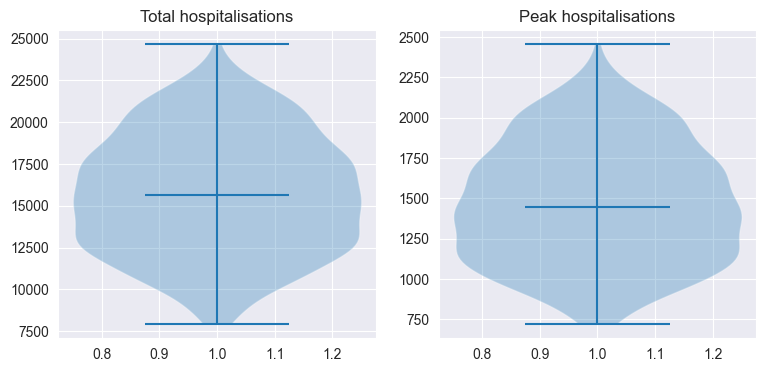

In [67]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
for index, result in enumerate(['Total hospitalisations', 'Peak hospitalisations']):
    axs[index].violinplot(results_and_sample_df[result],
                          showmeans=False,
                          showmedians=True)
    axs[index].set_title(result)

Now lets start plot % reductions in total hospitalisations and peak hospitalisations due to vaccination.

In [68]:
hospitalised_results_df

,Scenario,Total hospitalisations,Peak hospitalisations
0,Single infection at start,87.891455,26.156877
1,Starting prevalence of 0.01,29297.017609,2966.336876
2,Tests every 7 day resulting in 0.48 in isolati...,13349.153783,1083.910371
3,Do nothing event.,29297.017018,2966.336857
4,Vaccinating 0.7 population by day 90,20895.090581,2020.866274


In [69]:
baseline_value = hospitalised_results_df.loc[hospitalised_results_df['Scenario']=='Starting prevalence of 0.01',result].values[0]
to_plot = (baseline_value - results_and_sample_df[result])/baseline_value
to_plot *= 100
to_plot

0      36.459679
1      66.042348
2      52.360123
3      43.410153
4      27.451459
         ...    
995    61.425580
996    30.121941
997    49.669129
998    52.559669
999    53.485716
Name: Peak hospitalisations, Length: 1000, dtype: float64

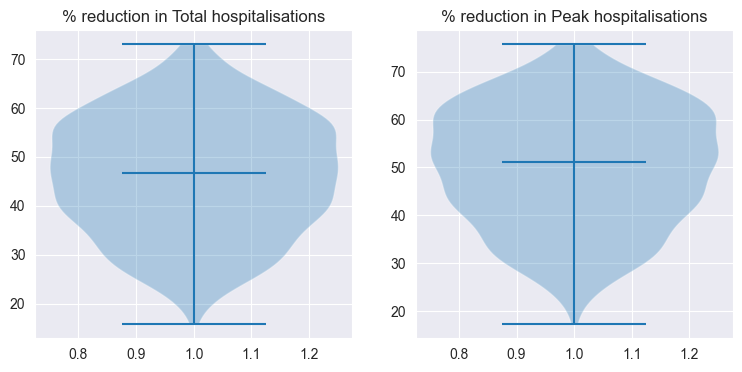

In [70]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
for index, result in enumerate(['Total hospitalisations', 'Peak hospitalisations']):
    baseline_value = hospitalised_results_df.loc[hospitalised_results_df['Scenario']=='Starting prevalence of 0.01',result].values[0]
    to_plot = (baseline_value - results_and_sample_df[result])/baseline_value
    to_plot *= 100
    axs[index].violinplot(to_plot,
                          showmeans=False,
                          showmedians=True)
    axs[index].set_title('% reduction in ' + result)